**Datasets**:Tess and Savee(Kaggle Datasets)

<span style="color:#fc0339;font-weight:bold;font-size:15px">Bundan sonraki bütün açıklamalar Türkçe olacaktır(başlıklar hariç). Bu Jupyter Notebook dosyası Turkcell Zeka Gücü Yapay Zeka Maratonu kapsamında hazırlanan bir projenin bir parçasıdır.</span>

In [1]:
#Temel kütüphanelerin ve ileride gerekli olabilecek kütüphanelerin yüklenmesi
#NOT:Eğer sonda "Done" yazmazsa bir hata oluşmuştur. Son kod satırı yüklenecek paketlerin fazla oluşundan dolayı yazılmıştır.
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
warnings.filterwarnings("ignore") 
import tensorflow as tf 
print ("Done")

Done


In [2]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:2 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]    
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [631 kB]
Get:9 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [447 B]
Err:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease             
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY C0BA5CE6DC6315A3
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [1

# Importing Data

In [3]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [4]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: Emotions, dtype: int64


In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: Emotions, dtype: int64


In [7]:
#Ana veri setimizi oluşturuldu ve data_paths.csv dosyasına kaydedildi.
df = pd.concat([ Tess_df, Savee_df], axis = 0)
df.to_csv("data_paths.csv",index=False)
df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [10]:
df.Emotions.value_counts()

neutral     520
fear        460
angry       460
disgust     460
sad         460
surprise    460
happy       460
Name: Emotions, dtype: int64

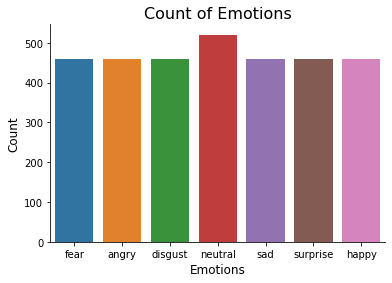

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
#Ses dosyalarını okuma
df,sr = librosa.load(file_path[0])
sr

22050

In [14]:
ipd.Audio(df,rate=sr)

# Mel Spectogram

### MEL FREQUENCY CEPSTRUM(FROM WIKIPEDIA)<br>
<i>In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.</i>
### MEL SPECTROGRAM NEDİR(ChatGPT'den)<br>
**Spektrogram**: Sesin frekans bileşenlerini zaman içinde görselleştirir. Bu, genellikle yatay eksende zamanı ve dikey eksende frekansı temsil eder. Renk yoğunluğu veya farklı renkler, sesin farklı frekans bileşenlerinin genliğini (veya enerji seviyesini) gösterir.<br>
**Mel Ölçeği (Mel Scale)**: İnsan işitme algısını daha iyi temsil etmek için frekansları ölçeklendirme yöntemidir. İnsan kulağı, frekanslardaki değişikliklere lineer değil, logaritmik olarak yanıt verir. Yani, düşük frekanslardaki küçük değişiklikleri kolayca fark ederken, yüksek frekanslardaki değişiklikleri daha geniş aralıklarla algılar. Mel ölçeği, bu insani algıya uygun bir frekans ölçeğidir.

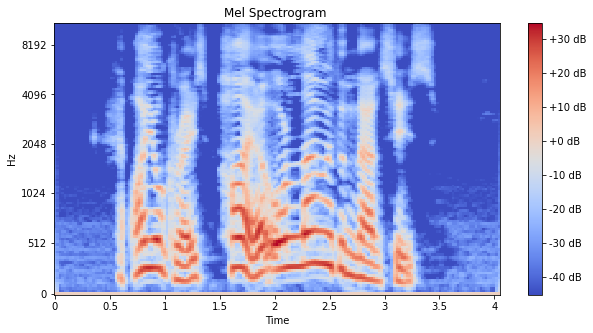

In [15]:
#Mel Spectogram Oluşturma
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=df, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

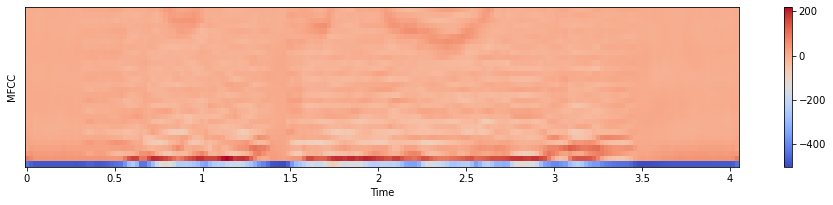

In [17]:
mfcc = librosa.feature.mfcc(y=df, sr=sr, n_mfcc=30)


plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(df,rate=sr)

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

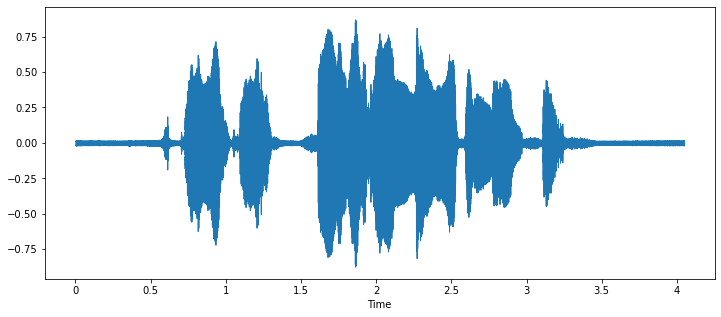

In [21]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=df, sr=sr)
ipd.Audio(df,rate=sr)

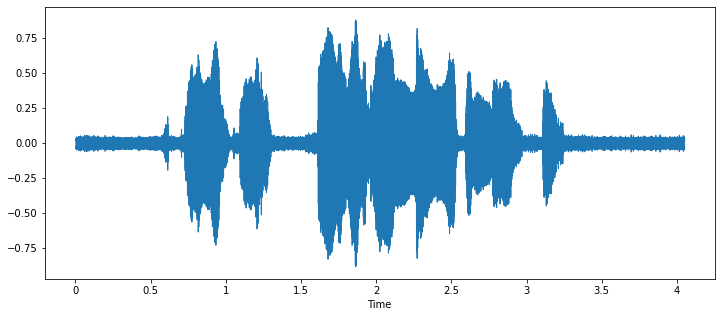

In [22]:
# AUDIO WITH NOISE
x = noise(df)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

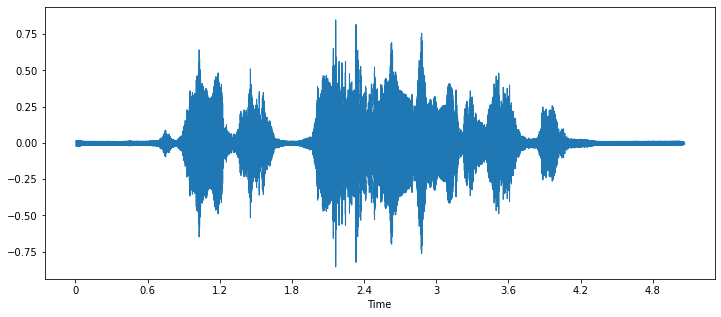

In [23]:
# STRETCHED AUDIO
x = stretch(df)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

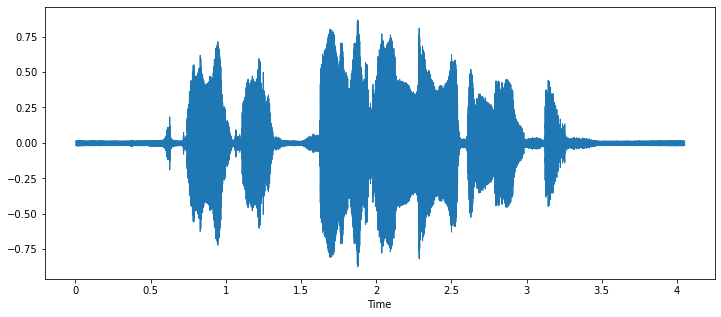

In [24]:
# SHIFTED AUDIO
x = shift(df)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

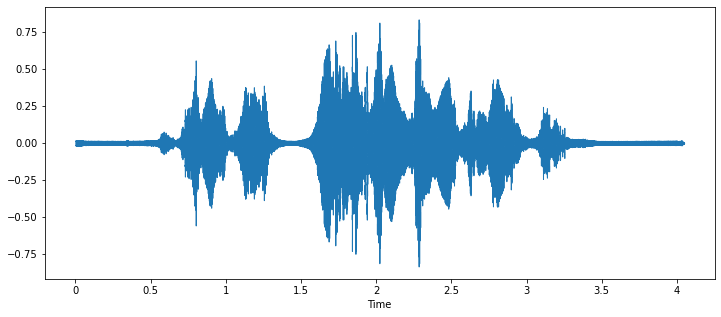

In [25]:
# AUDIO WITH PITCH
x = pitch(df, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [26]:
#Kaggle'deki bir notbook'tan alıntıdır.
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

# Features

In [33]:
emotion_df = pd.read_csv('data_paths.csv')

In [35]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
x,y=[],[]
for path,emotion,index in tqdm (zip(emotion_df.Path,emotion_df.Emotions,range(emotion_df.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        x.append(i)
        y.append(emotion)
print(f'Done. Number of audios has been precossed{index}.')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  4.95it/s]

0 audio has been processed


501it [02:25,  3.33it/s]

500 audio has been processed


1001it [05:34,  2.71it/s]

1000 audio has been processed


1501it [09:07,  2.28it/s]

1500 audio has been processed


2001it [12:25,  2.62it/s]

2000 audio has been processed


2501it [15:33,  2.28it/s]

2500 audio has been processed


3280it [21:43,  2.52it/s]

Done. Number of audios has been precossed3279.
Time:  1303.6876885740003


In [36]:
len(x), len(y), emotion_df.Path.shape

(13120, 13120, (3280,))

# Saving features

In [37]:
Emotions = pd.DataFrame(x)
Emotions['Emotions'] = y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.028809,0.051758,0.071777,0.066895,0.074707,0.076660,0.071777,0.081543,0.070312,0.060059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.028809,0.052734,0.072754,0.068848,0.078613,0.080566,0.075684,0.084473,0.071289,0.059082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.030273,0.046875,0.077148,0.078125,0.088379,0.090332,0.078125,0.075195,0.063477,0.055664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.031250,0.046875,0.078125,0.079102,0.088379,0.089355,0.076172,0.072266,0.060547,0.053711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [38]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.028809,0.051758,0.071777,0.066895,0.074707,0.076660,0.071777,0.081543,0.070312,0.060059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.028809,0.052734,0.072754,0.068848,0.078613,0.080566,0.075684,0.084473,0.071289,0.059082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.030273,0.046875,0.077148,0.078125,0.088379,0.090332,0.078125,0.075195,0.063477,0.055664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.031250,0.046875,0.078125,0.079102,0.088379,0.089355,0.076172,0.072266,0.060547,0.053711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [39]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [40]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(13120, 2377)

In [42]:
print(np.sum(Emotions.isna()))

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64


# Data preparation

In [43]:
x = Emotions.iloc[: ,:-1].values
y = Emotions['Emotions'].values

In [44]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [45]:
print(y.shape)
x.shape

(13120, 7)


(13120, 2376)

In [46]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10496, 2376), (10496, 7), (2624, 2376), (2624, 7))

In [50]:
#Model için yeniden boyutlandırma
x_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [52]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [53]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [54]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [55]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((10496, 2376, 1, 1), (10496, 7), (2624, 2376, 1, 1), (2624, 7))

In [60]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization_6 (Batch (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1188, 512)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 594, 512)         

In [61]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/20
164/164 [==============================] - 37s 176ms/step - loss: 0.7574 - accuracy: 0.7632 - val_loss: 0.5704 - val_accuracy: 0.7946
Epoch 2/20
164/164 [==============================] - 28s 173ms/step - loss: 0.3095 - accuracy: 0.8931 - val_loss: 0.3668 - val_accuracy: 0.8792
Epoch 3/20
164/164 [==============================] - 28s 173ms/step - loss: 0.1856 - accuracy: 0.9388 - val_loss: 0.1575 - val_accuracy: 0.9474
Epoch 4/20
164/164 [==============================] - 28s 173ms/step - loss: 0.1131 - accuracy: 0.9629 - val_loss: 0.1956 - val_accuracy: 0.9310
Epoch 5/20
164/164 [==============================] - 28s 173ms/step - loss: 0.0798 - accuracy: 0.9729 - val_loss: 0.1189 - val_accuracy: 0.9615
Epoch 6/20
164/164 [==============================] - 28s 173ms/step - loss: 0.0613 - accuracy: 0.9807 - val_loss: 0.1002 - val_accuracy: 0.9668
Epoch 7/20
164/164 [==============================] - 28s 173ms/step - loss: 0.0370 - accuracy: 0.9895 - val_loss: 0.0500 - val_ac

82/82 [==============================] - 2s 23ms/step - loss: 0.0079 - accuracy: 0.9977
Accuracy of our model on test data :  99.77133870124817 %


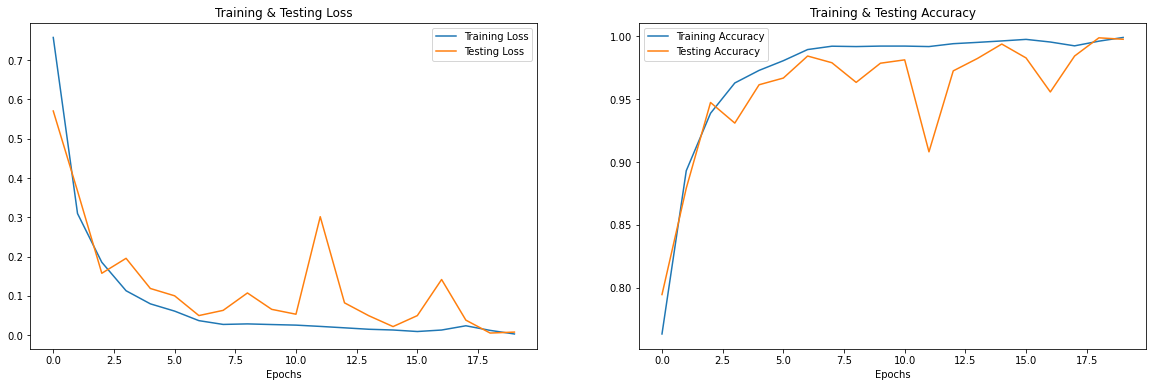

In [62]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [64]:
#Modeli erken durdmanın çalışmasına gerek kalmadı bu nedenle doğrudan modeli kaydedebilirim
model.save('voice_model.h5')